# Optimal Experimental Design for Conformer Search

Conformers define the different structures with the same bonding graph but different coordinates. Finding the lowest-energy conformation is a common task in molecular modeling, and one that often requires significant time to solve. This homework is designed to explore the use of optimal experimental design techniques, which have recently emerged as a potential tool for accelerating the conformer search.

In [1]:
import warnings
warnings.simplefilter('ignore')
from matplotlib import pyplot as plt
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from modAL.models import CommitteeRegressor
from modAL.acquisition import max_UCB
from rdkit.Chem import AllChem, DataStructs
from sklearn.gaussian_process import GaussianProcessRegressor
from modAL.models import BayesianOptimizer
from sklearn.gaussian_process import kernels
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_absolute_error
from modAL.acquisition import max_EI
from modAL.disagreement import max_std_sampling
from rdkit import Chem
from tqdm import tqdm
import pandas as pd
import numpy as np

##  Problem 1: Active Learning for $n$-butane

*Setup: Loading Conformer Data*

In [2]:
butane = pd.read_csv('data/n-butane.csv')

In [3]:
# find the phi_2 that minimize the global energy
index_energy_pair = []
index = 0
for phi2, group in butane.groupby('phi2'):
    index_energy_pair.append((group, index, np.mean(group['energy'])))
    index += 1
index_energy_pair.sort(key=lambda a : a[-1])
subset = index_energy_pair[0][0]
print('phi_2: ', subset['phi2'].iloc[0])

phi_2:  180.0


As we can see, the system has an overall lowest energy when $\phi_2$ is in the "anti" configuration. Let's choose this configuration as our subset.

### Part A: Learning a Potential Enery Surface
Our first ingredient is to learn a function that can predict energy as a function of dihedral angles.

Dihedral angles are periodic (e.g., 0 and 360 are the same) and we can create a kernel that reflects that by using a periodic kernel:

$K(x, y) = \sum_i \exp(-2 \frac{\sin^2(\pi (x_i - y_i)^2/p)}{l^2})$

We can use this custom kernel with Scikit-Learn's GuassianProcessRegressor by writing it a function to use with the PairwiseKernel class, which accepts custom kernels:

In [4]:
def elementwise_expsine_kernel(x, y, gamma=10, p=360):
    """Compute the expoonential sine kernel
    
    Args:
        x, y: Coordinates to be compared
        gamma: Length scale of the kernel
        p: Periodicity of the kernel
    Returns:
        Kernel metric
    """
    
    # Compute the distances between the two points
    dists = np.subtract(x, y)
    
    # Compute the sine with a periodicity of p
    sine_dists = np.sin(np.pi * dists / p)
    
    # Return exponential of the squared kernel
    return np.sum(np.exp(-2 * np.power(sine_dists, 2) / gamma ** 2), axis=-1)

gpr = GaussianProcessRegressor(
    kernel=kernels.PairwiseKernel(metric=elementwise_expsine_kernel),
    # Starts using different guesses for parameters to achieve better fitting
    n_restarts_optimizer=4, 
)

kernel = 1.0 * RBF(1.0)
# kernel = RBF()
rbf = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=16,
)

In [5]:
seed_data, explore_data = train_test_split(subset, train_size=2)

In [6]:
gpr.fit(np.vstack(seed_data['phi1']), seed_data['energy'])
rbf.fit(np.vstack(seed_data['phi1']), seed_data['energy'])

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=16)

- Plot the mean and standard deviations of the predictions as a function of phi_1. Which function is a better approximator of the energy? (You may want to run the fitting multiple times to avoid basing your conclusion on haphazard, while you only need to show two plots in the notebook, one for each kernel, respectively).

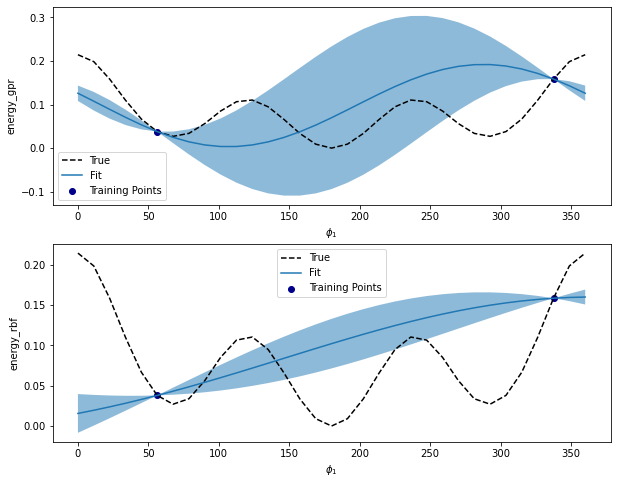

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax1 = ax[0]
ax1.plot(subset['phi1'], subset['energy'], 'k--', label='True')

y_pred, y_std = gpr.predict(np.vstack(subset['phi1']), return_std=True)
ax1.plot(subset['phi1'], gpr.predict(np.vstack(subset['phi1'])), label='Fit')
ax1.fill_between(np.vstack(subset['phi1'])[:, 0], y_pred - y_std, y_pred + y_std, alpha=0.5)
ax1.scatter(np.vstack(seed_data['phi1']), seed_data['energy'], label='Training Points', color='darkblue')

ax1.set_xlabel(r'$\phi_{1}$')
ax1.set_ylabel('energy_gpr')
ax1.legend()

ax2 = ax[1]
ax2.plot(subset['phi1'], subset['energy'], 'k--', label='True')

y_pred, y_std = rbf.predict(np.vstack(subset['phi1']), return_std=True)
ax2.plot(subset['phi1'], rbf.predict(np.vstack(subset['phi1'])), label='Fit')
ax2.fill_between(np.vstack(subset['phi1'])[:, 0], y_pred - y_std, y_pred + y_std, alpha=0.5)
ax2.scatter(np.vstack(seed_data['phi1']), seed_data['energy'], label='Training Points', color='darkblue')

ax2.set_xlabel(r'$\phi_{1}$')
ax2.set_ylabel('energy_rbf')
ax2.legend()

GaussianProcessRegressor based on elementwise_expsine_kernel is a better approximator of energy 

Next, go back to the original 2D dataset with no constraint on phi_2. Train a series of models with each of the two kernels, with randomly-selected subsets of 3, 10, 30, and 100 points (in all there should be 2 x 4 models). Measure the error on the full dataset.

- Plot the error in the Sine kernel model and the RBF kernel model as a function of training set size. Which model performs better? Explain why.

In [8]:
train_sizes = [3, 10, 30, 100]
results = []
for train_size in tqdm(train_sizes):
    seed_data, explore_data = train_test_split(butane, train_size=train_size)
    gpr.fit(np.vstack(seed_data['phi1']), seed_data['energy'])
    gpr_pred = gpr.predict(np.vstack(butane['phi1']))
    results.append({
        'model': 'gpr',
        'train_size': train_size,
        'MAE': mean_absolute_error(gpr_pred, butane['energy']),
    }
    )
    rbf.fit(np.vstack(seed_data['phi1']), seed_data['energy'])
    rbf_pred = rbf.predict(np.vstack(butane['phi1']))
    results.append({
        'model': 'rbf',
        'train_size': train_size,
        'MAE': mean_absolute_error(rbf_pred, butane['energy']),
    }
    )
results = pd.DataFrame(results)

100%|██████████| 4/4 [00:55<00:00, 13.90s/it]


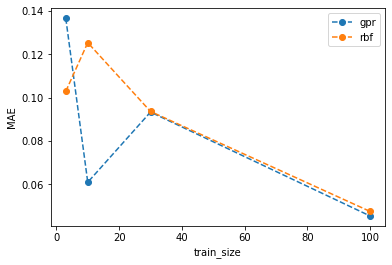

In [9]:
fig, ax = plt.subplots()
for model, group in results.groupby('model'):
    ax.plot(group['train_size'], group['MAE'], '--o', label=model)
ax.set_xlabel('train_size')
ax.set_ylabel('MAE')
ax.legend()

After running the test for multiple times, it turns out that Sine kernel models works better. The reason is that Sine kernel reflects periodic property in the model, which is more physical, while RBF kernel doesn't.

### Part B: Bayesian Optimization for Conformer Search

In [10]:
initial_data = butane.sample(4)
input_cols = ['phi1', 'phi2']
optimizer = BayesianOptimizer(
    estimator=gpr,
    X_training=initial_data[input_cols].values,  # .values removes Panda's indices
    # negative because modAL is designed to maximize a function
    y_training=-initial_data['energy'].values,  
    query_strategy=max_EI
)
for i in tqdm(range(16)):
    optimizer.predict(butane[input_cols].values)
    chosen_inds, chosen_coords = optimizer.query(butane[input_cols].values)
    optimizer.teach(
        butane[input_cols].iloc[chosen_inds].values, 
        -butane['energy'].iloc[chosen_inds].values
    )

100%|██████████| 16/16 [00:20<00:00,  1.28s/it]


In [11]:
# initial_data = butane.sample(4)
optimizer_max_std = BayesianOptimizer(
    estimator=gpr,
    X_training=initial_data[input_cols].values,  # .values removes Panda's indices
    # negative because modAL is designed to maximize a function
    y_training=-initial_data['energy'].values,  
    query_strategy=max_std_sampling
)
for i in tqdm(range(16)):
    optimizer_max_std.predict(butane[input_cols].values)
    chosen_inds, chosen_coords = optimizer_max_std.query(butane[input_cols].values)
    optimizer_max_std.teach(
        butane[input_cols].iloc[chosen_inds].values, 
        -butane['energy'].iloc[chosen_inds].values
    )

100%|██████████| 16/16 [00:18<00:00,  1.18s/it]


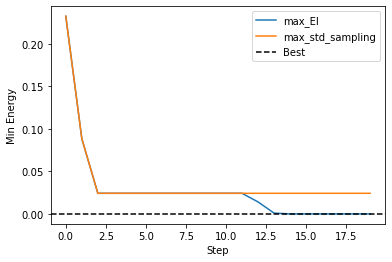

In [12]:
fig, ax = plt.subplots()

ax.plot(-1 * np.maximum.accumulate(optimizer.y_training), label='max_EI')
ax.plot(-1 * np.maximum.accumulate(optimizer_max_std.y_training), label='max_std_sampling')

ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [butane['energy'].min()] * 2, 'k--', label='Best')

ax.set_ylabel('Min Energy')
ax.set_xlabel('Step')
        
ax.legend()

Maximum expected improvement seems to find the lower energy (higher minus-energy) more quickly as training process going on. The reason is that: 
- max Expected improvement is designed to query new data point that has a higher expected value, which, in our case, is higher minus-energy. As for max_std, it is used to sample point that has higher standard deviation, which is more likely to be used in predicting the overall target function.

##  Problem 2: Optimizing cysteine
**Setup: Global optimization with for cysteine structure**

Our background notebook and utility functions define the data and functions we need to quickly evaluate the energy of a cysteine molecule given the dihedral angles.

First, load them in using pickle

In [13]:
import pickle as pkl

# Molecular structure of cysteine
with open('data/cysteine-atoms.pkl', 'rb') as fp:
    cysteine = pkl.load(fp)

# Definitions for the dihedral angles of cysteine
with open('data/dihedrals.pkl', 'rb') as fp:
    dihedrals = pkl.load(fp)

Now, define a function to evaluate the energy given new dihedral angles

In [14]:
from confutils import set_dihedrals_and_relax

def evaluate_energy(angles):
    """Compute the energy of a cysteine molecule given dihedral angles
    
    Args:
        angles: List of dihedral angles
    Returns:
        energy of the structure
    """
    return set_dihedrals_and_relax(
        cysteine,
        zip(angles, dihedrals)
    )

We use a simple "generate random points" and minimize them strategy. This strategy generates a series of random points, uses a local optimizer (Nelder-Mead) to find the nearby minimum in energy, and then returns a list of all of the points sampled for the optimizer's consideration. We use the optimizer's model rather than the evaluate_energy function so that this function is very fast.

In [15]:
from scipy.optimize import minimize
import numpy as np

def get_search_space(optimizer: BayesianOptimizer, n_samples: int = 32):
    """Generate many samples by attempting to find the minima using a multi-start local optimizer
    
    Args: 
        optimizer: Optimizer being used to perform Bayesian optimization
        n_samples: Number of initial starts of the optimizer to use. 
            Will return all points sampled by the optimizer
    Returns:
        List of points to be considered
    """
    
    # Generate random starting points
    init_points = np.random.uniform(0, 360, size=(n_samples, 5))
    
    # Use local optimization to find the minima near these
    points_sampled = []  # Will hold all samples tested by the optimizer
    for init_point in init_points:
        minimize(
            # Define the function to be optimized
            #  The optimizer requires a 2D input and returns the negative energy
            #  We make our inputs 2D and compute the negative energy with a lambda function
            lambda x: -optimizer.predict([x]),  # Model predicts the negative energy and requires a 2D array,
            init_point,  # Initial guess
            method='nelder-mead',  # A derivative-free optimizer
             # Stores the points sampled by the optimizer at each step in "points_sampled"
            callback=points_sampled.append
        )
    
    # Combine the results from the optimizer with the initial points sampled
    all_points = np.vstack([
        init_points,
        *points_sampled
    ])
    return all_points

### Part A: Building a global optimization algorithm
Generate a set of 4 initial points where the values for each of the 5 dihedrals are chosen randomly from between 0 and 360 degrees (HINT use np.random.uniform).

Compute their energy and use them to create a Bayesian optimizer with the EI query strategy.

Write a loop that follows the following procedure:

Use the get_search_space function to create a series of points to be sampled
Select the best points to query with the optimizer
Evaluate the energy of the best points using evaluate_energy so that the results are more accurate, with reasonable sacrifice in efficiency
Add the best points and new energies to the training set of the optimizer
Run the loop 32 times to try to find the lowest energy conformer. This may take a half hour.

Plot the energy of each sampled point as a function of step. Describe the energies of the conformers compared to that of the one produced by OpenBabel ($E = -19641.7084$ Ha)

In [16]:
phis = np.random.uniform(0, 360, size=(4, 5))  # Random confomers
energies = np.array([ evaluate_energy(phi) for phi in tqdm(phis) ])

100%|██████████| 4/4 [00:18<00:00,  4.73s/it]


In [17]:
optimizer = BayesianOptimizer(
    estimator=gpr,
    X_training=phis,  # .values removes Panda's indices
    # negative because modAL is designed to maximize a function
    y_training=-energies,  
    query_strategy=max_EI
)

In [18]:
for i in tqdm(range(32)):
    points = get_search_space(optimizer=optimizer)
    chosen_inds, chosen_coords = optimizer.query(points)
    optimizer.teach(
        points[chosen_inds], 
        -1 * np.array([evaluate_energy(points[chosen_inds].flatten())])
    ) 

100%|██████████| 32/32 [09:17<00:00, 17.41s/it]


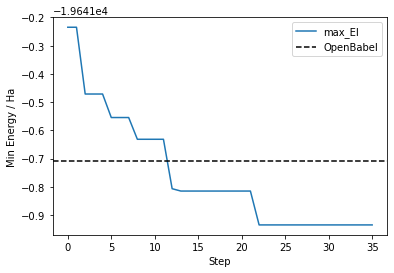

In [19]:
fig, ax = plt.subplots()

ax.plot(-1 * np.maximum.accumulate(optimizer.y_training), label='max_EI')

ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [-19641.7084] * 2, 'k--', label='OpenBabel')

ax.set_ylabel('Min Energy / Ha')
ax.set_xlabel('Step')
        
ax.legend()